# Read and analyze Norrøna Data 

This Notebook read in the Norrona Dataset, train the ALS implicit algorithm and evalute the model 
both in terms of utility of the user (ndcg) and in terms of diferent fairness measures. 

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
# Add parent dir to path, so that python finds the lenskit package
sys.path.insert(0,parentdir)

Read relevant packages in Lenskit  

In [2]:
from lenskit.metrics import dataGenerator
from lenskit import batch, topn, util, topnFair
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, user_knn as knn

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline

Read the Norrona dataset 

In [4]:
ratings = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/norrona_10000_name.csv', sep=',',
                      names=['user', 'item', 'name','rating'], header=0)
ratings.head()

,user,item,name,rating
0,4a0b96a4-e6a0-41b9-9ecd-7212413c4d9e,2003-18 2295,lyngen Windstopper hybrid Jacket (M),1
1,77e6a03c-a222-48bb-8737-6c7bb3572a52,5252-12 2320,røldal warm3 Jacket (W),1
2,424d96d4-d592-4c10-9ceb-e2e2774abd6e,1062-17 2335,lofoten dri1 PrimaLoft170 short Gloves,2
3,03a116ee-18d5-4968-93f1-ae62d1c35684,1805-17 2345,falketind Alpha60 Jacket (M),1
4,9359335c-8b7d-449f-a2c0-a84477a6f229,1058-17 6725,lofoten Gore-Tex Pro Light Pants (W),1


In [5]:
algo_implicitALS = als.ImplicitMF(50)
algo_als = als.BiasedMF(50)

In [6]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [7]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating', 'name']], 2, xf.SampleFrac(0.4)):
    test_data.append(test)
    all_recs.append(eval('Implicit_ALS', algo_implicitALS, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

In [8]:
all_recs = pd.concat(all_recs, ignore_index=True)
test_data = pd.concat(test_data, ignore_index=True)

In [9]:
all_recs.head()

,item,score,user,rank,Algorithm
0,5311-13 5610,0.453949,0275e660-94f8-4186-a43a-583ea327f24a,1,Implicit_ALS
1,1058-16 7718,0.276982,0275e660-94f8-4186-a43a-583ea327f24a,2,Implicit_ALS
2,3032-16 6755,0.273706,0275e660-94f8-4186-a43a-583ea327f24a,3,Implicit_ALS
3,2409-19 8860,0.249205,0275e660-94f8-4186-a43a-583ea327f24a,4,Implicit_ALS
4,4057-16 8850,0.248626,0275e660-94f8-4186-a43a-583ea327f24a,5,Implicit_ALS


In [10]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

C:\Users\josse\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


ndcg
user                                 Algorithm         
0275e660-94f8-4186-a43a-583ea327f24a ALS            0.0
                                     Implicit_ALS   0.0
037a13fb-0851-430c-9d37-0b6340874c45 ALS            0.0
                                     Implicit_ALS   0.0
03957f3b-b9af-45e0-825a-986f43615abc ALS            0.0

In [11]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS             0.023108
Implicit_ALS    0.028483
Name: ndcg, dtype: float64

In [12]:
#ratings1 = ratings[["item", "name"]]
all_recs_joined = all_recs.join(ratings[["item", "name"]].set_index("item"), on='item')
all_recs_joined['Gender'] = np.where(all_recs_joined["name"].str.contains("(M)",case=False, regex=True),"Male","Female")
dummies = pd.get_dummies(all_recs_joined.Gender)
res1 = pd.concat([all_recs_joined, dummies], axis=1)
res1.head()

C:\Users\josse\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


,item,score,user,rank,Algorithm,name,Gender,Female,Male
0,5311-13 5610,0.453949,0275e660-94f8-4186-a43a-583ea327f24a,1,Implicit_ALS,narvik Gore-Tex 2L Pants (M),Male,0,1
0,5311-13 5610,0.453949,0275e660-94f8-4186-a43a-583ea327f24a,1,Implicit_ALS,narvik Gore-Tex 2L Pants (M),Male,0,1
0,5311-13 5610,0.453949,0275e660-94f8-4186-a43a-583ea327f24a,1,Implicit_ALS,narvik Gore-Tex 2L Pants (M),Male,0,1
0,5311-13 5610,0.453949,0275e660-94f8-4186-a43a-583ea327f24a,1,Implicit_ALS,narvik Gore-Tex 2L Pants (M),Male,0,1
0,5311-13 5610,0.453949,0275e660-94f8-4186-a43a-583ea327f24a,1,Implicit_ALS,narvik Gore-Tex 2L Pants (M),Male,0,1


In [13]:
#res1.groupby('Gender').count()
print(res1.Gender.value_counts())
print(res1.item.nunique())
res2 = res1.loc[res1['Gender'] == "Female"]
res2.head()
res2.item.nunique()
#res1.user.nunique()
#res1.Gender.nunique()

#print(res1.shape[0])


Male      390972
Female    192580
Name: Gender, dtype: int64
1179


435

In [14]:
res= list(res1.iloc[:,7:])
print(res)

['Female', 'Male']


In [15]:


rlaFair = topnFair.FairRecListAnalysis(['user', "Algorithm"])
rlaFair.add_metric("rND")
rlaFair.add_metric("rKL")
rlaFair.add_metric("rRD")
rlaFair.add_metric("div")
rlaFair.add_metric("dem_parity")
results = rlaFair.compute(res1, test_data, "Female", res, res1.item.nunique(),res2.item.nunique())
results.head()




rND       rKL  \
user                                 Algorithm                          
0275e660-94f8-4186-a43a-583ea327f24a ALS           0.865366  0.808442   
                                     Implicit_ALS  0.792541  0.684075   
037a13fb-0851-430c-9d37-0b6340874c45 ALS           0.773789  0.675893   
                                     Implicit_ALS  0.548633  0.450887   
03957f3b-b9af-45e0-825a-986f43615abc ALS           0.638681  0.480889   

                                                        rRD  div  dem_parity  
user                                 Algorithm                                
0275e660-94f8-4186-a43a-583ea327f24a ALS           1.317978  1.0    0.754979  
                                     Implicit_ALS  0.923423  1.0    0.380532  
037a13fb-0851-430c-9d37-0b6340874c45 ALS           1.087852  1.0    0.649364  
                                     Implicit_ALS  0.543308  1.0    0.181829  
03957f3b-b9af-45e0-825a-986f43615abc ALS           0.764083  1.0    0.505433

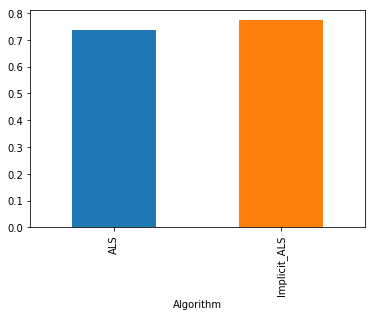

In [16]:
results.groupby('Algorithm').rND.mean().plot.bar()

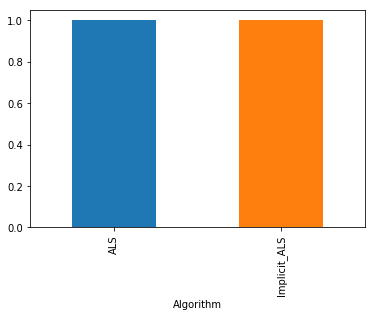

In [17]:
results.groupby('Algorithm').div.mean().plot.bar()